<font face="Chalkboard" color="darkgreen" size=6pt> LOWESS - Testing and Real Data Applications</font>

The main idea is that we want to use many different kernels for the weights and validate the results.

In [11]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 120

In [20]:
import numpy as np
import pandas as pd
from math import ceil
from scipy import linalg
from scipy.interpolate import interp1d

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.model_selection import train_test_split as tts, KFold
from sklearn.metrics import mean_squared_error as mse
import statsmodels.api as sm
from math import ceil
from IPython.display import Image
from IPython.display import display
plt.style.use('seaborn-white')

# the following line(s) are necessary if you want to make SKlearn compliant functions
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

In [13]:
lm = LinearRegression()

## Kernel Definitions

In [10]:
# Gaussian Kernel
def Gaussian(x):
  return np.where(np.abs(x)>4,0,1/(np.sqrt(2*np.pi))*np.exp(-1/2*x**2))

In [14]:
# Tricubic Kernel
def Tricubic(x):
  return np.where(np.abs(x)>1,0,70/81*(1-np.abs(x)**3)**3)

In [15]:
# Epanechnikov Kernel
def Epanechnikov(x):
  return np.where(np.abs(x)>1,0,3/4*(1-np.abs(x)**2)) 

In [16]:
# Quartic Kernel
def Quartic(x):
  return np.where(np.abs(x)>1,0,15/16*(1-np.abs(x)**2)**2) 

## Useful Functions

Big Idea: we need to acommodate new data points in a test set. We can only get weights from the train set.

In [17]:
def kernel_function(xi,x0,kern, tau): 
    return kern((xi - x0)/(2*tau))

In [18]:
def weights_matrix(x,x_new,kern,tau):
  if np.isscalar(x_new):
    return kernel_function(x,x_new,kern,tau)
  else:
    n = len(x_new)
    return np.array([kernel_function(x,x_new[i],kern,tau) for i in range(n)]) 

In [ ]:
def lowess(x, y,x_new, kern, tau=0.05):
    # tau is called bandwidth K((x-x[i])/(2*tau))
    # tau is a hyper-parameter
    w = weights_matrix(x,x_new,kern,tau) 
    if np.isscalar(x_new):
      lm.fit(np.diag(w).dot(x.reshape(-1,1)),np.diag(w).dot(y.reshape(-1,1)))
      yest = lm.predict([[x_new]])[0][0]
    else:
      n = len(x_new)
      yest = np.zeros(n)
      #Looping through all x-points
      for i in range(n):
        lm.fit(np.diag(w[i,:]).dot(x.reshape(-1,1)),np.diag(w[i,:]).dot(y.reshape(-1,1)))
        yest[i] = lm.predict(x_new[i].reshape(-1,1)) 

    return yest

## Scikit-Learn Compliant Functions

Main Idea: we want to define a model regressor that can be used as model.fit/model.predict, and that also allows sklearn GridSearchCV for tuning hyperparameters.

*Self* represents the instance of the class. By using the “self”  we can access the attributes and methods of the class in python. It binds the attributes with the given arguments.

In [163]:
class Lowess:
    def __init__(self, kernel = Gaussian, tau=0.05):
        self.kernel = kernel
        self.tau = tau
    
    def fit(self, x, y):
        kernel = self.kernel
        tau = self.tau
        # w = weights_matrix(x,x,kernel,tau) 
        # if np.isscalar(x):
        #   lm.fit(np.diag(w).dot(x.reshape(-1,1)),np.diag(w).dot(y.reshape(-1,1)))
        #   yest = lm.predict([[x]])[0][0]
        # else:
        #   n = len(x)
        #   yest = np.zeros(n)
        #   #Looping through all x-points
        #   for i in range(n):
        #     lm.fit(np.diag(w[i,:]).dot(x.reshape(-1,1)),np.diag(w[i,:]).dot(y.reshape(-1,1)))
        #     yest[i] = lm.predict(x[i].reshape(-1,1)) 
        self.xtrain_ = x
        self.yhat_ = y

    def predict(self, x_new):
        check_is_fitted(self)
        x = self.xtrain_
        y = self.yhat_

        w = weights_matrix(x,x_new,self.kernel,self.tau)

        if np.isscalar(x_new):
          lm.fit(np.diag(w).dot(x.reshape(-1,1)),np.diag(w).dot(y.reshape(-1,1)))
          yest = lm.predict([[x_new]])[0][0]
        else:
          n = len(x_new)
          yest_test = np.zeros(n)
          #Looping through all x-points
          for i in range(n):
            lm.fit(np.diag(w[i,:]).dot(x.reshape(-1,1)),np.diag(w[i,:]).dot(y.reshape(-1,1)))
            yest_test[i] = lm.predict(x_new[i].reshape(-1,1))
        return yest_test

## Testing on Simulated Data

In [139]:
#Initializing noisy non linear data
x = np.linspace(0,4,401)
noise = np.random.normal(loc = 0, scale = .2, size = len(x))
y = np.sin(x**2 * 1.5 * np.pi ) 
ynoisy = y + noise

In [141]:
xtrain, xtest, ytrain, ytest = tts(x,ynoisy,test_size=0.2,shuffle=True,random_state=123)

In [182]:
%%time
# test the regressor
model = Lowess(kernel=Epanechnikov,tau=0.02)
model.fit(xtrain,ytrain)
mse(model.predict(xtest),ytest)

CPU times: user 61 ms, sys: 44 ms, total: 105 ms
Wall time: 69.1 ms


0.05769825070641123

In [192]:
%%time
model_rf = RandomForestRegressor(n_estimators=200, max_depth=10)
model_rf.fit(xtrain.reshape(-1,1),ytrain)
mse(model_rf.predict(xtest.reshape(-1,1)),ytest)

CPU times: user 309 ms, sys: 0 ns, total: 309 ms
Wall time: 325 ms


0.20234611545758763

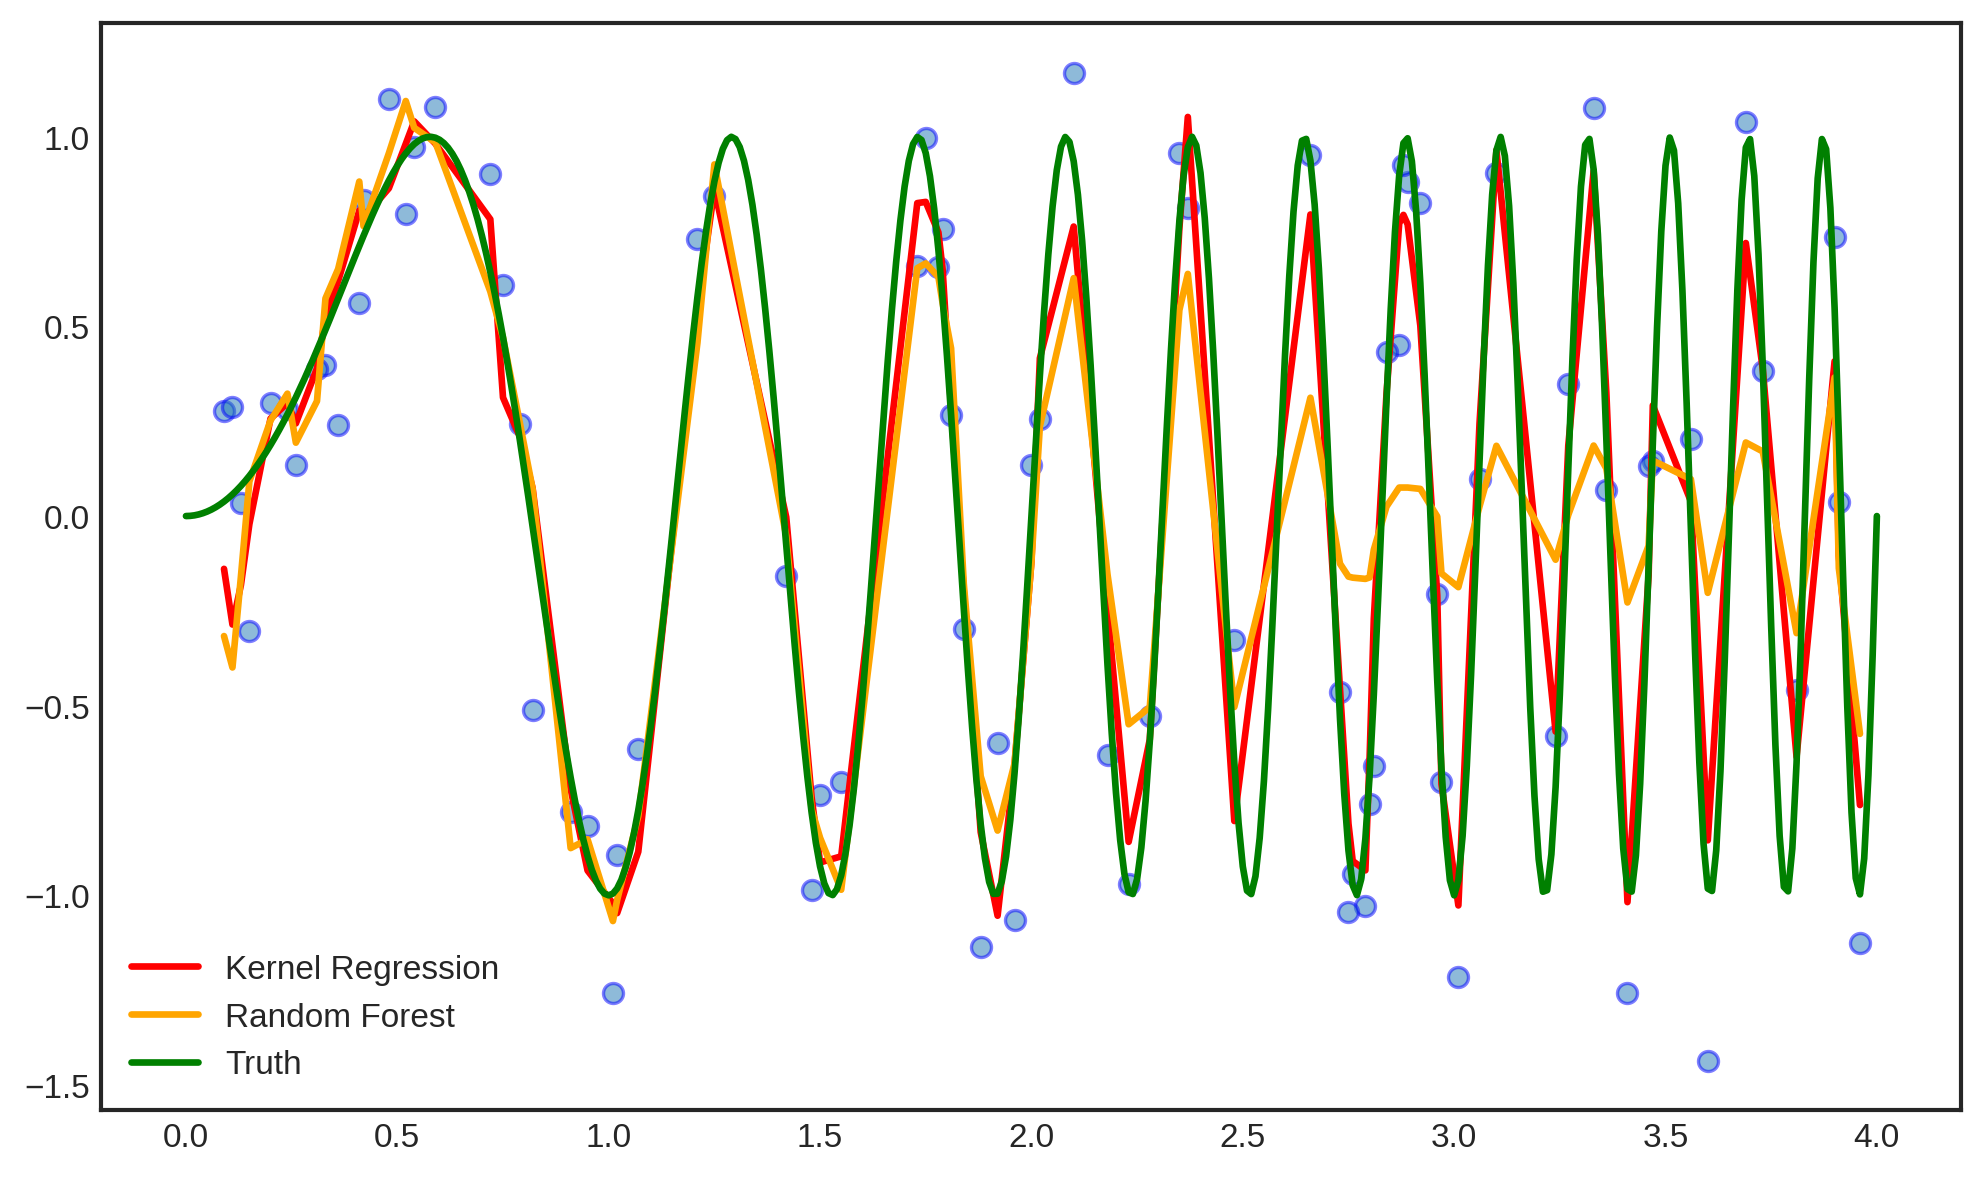

In [193]:
plt.figure(figsize=(10,6))
plt.scatter(xtest,ytest,ec='blue',alpha=0.5)
plt.plot(xtest[np.argsort(xtest)],model.predict(xtest[np.argsort(xtest)]),color='red',lw=2,label='Kernel Regression')
plt.plot(xtest[np.argsort(xtest)],model_rf.predict(xtest[np.argsort(xtest)].reshape(-1,1)),color='orange',lw=2,label='Random Forest')
plt.plot(x,y,color='green',lw=2,label='Truth')
plt.legend()
plt.show()

In [ ]:
# approach by Alex Gramfort

def lowess_ag(x, y, f=2. / 3., iter=3):
    """lowess(x, y, f=2./3., iter=3) -> yest
    Lowess smoother: Robust locally weighted regression.
    The lowess function fits a nonparametric regression curve to a scatterplot.
    The arrays x and y contain an equal number of elements; each pair
    (x[i], y[i]) defines a data point in the scatterplot. The function returns
    the estimated (smooth) values of y.
    The smoothing span is given by f. A larger value for f will result in a
    smoother curve. The number of robustifying iterations is given by iter. The
    function will run faster with a smaller number of iterations.
    """
    n = len(x)
    r = int(ceil(f * n))
    h = [np.sort(np.abs(x - x[i]))[r] for i in range(n)]
    w = np.clip(np.abs((x[:, None] - x[None, :]) / h), 0.0, 1.0)
    w = (1 - w ** 3) ** 3
    yest = np.zeros(n)
    delta = np.ones(n)
    for iteration in range(iter):
        for i in range(n):
            weights = delta * w[:, i]
            b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
            A = np.array([[np.sum(weights), np.sum(weights * x)],
                          [np.sum(weights * x), np.sum(weights * x * x)]])
            beta = linalg.solve(A, b)
            yest[i] = beta[0] + beta[1] * x[i]

        residuals = y - yest
        s = np.median(np.abs(residuals))
        delta = np.clip(residuals / (6.0 * s), -1, 1)
        delta = (1 - delta ** 2) ** 2

    return yest

## We want a Train-Test situation for validating our function

##<font face='menlo' size=6pt> Applications with Real Data </font>

A different verison of locally weighted regression:

In [ ]:
def lowess_reg(x, y, xnew, kern, tau):
    # tau is called bandwidth K((x-x[i])/(2*tau))
    # IMPORTANT: we expect x to the sorted increasingly
    n = len(x)
    yest = np.zeros(n)

    #Initializing all weights from the bell shape kernel function    
    w = np.array([kern((x - x[i])/(2*tau)) for i in range(n)])     
    
    #Looping through all x-points
    for i in range(n):
        weights = w[:, i]
        b = np.array([np.sum(weights * y), np.sum(weights * y * x)])
        A = np.array([[np.sum(weights), np.sum(weights * x)],
                    [np.sum(weights * x), np.sum(weights * x * x)]])
        #theta = linalg.solve(A, b) # A*theta = b
        theta, res, rnk, s = linalg.lstsq(A, b)
        yest[i] = theta[0] + theta[1] * x[i] 
    f = interp1d(x, yest,fill_value='extrapolate')
    return f(xnew)
   

In [ ]:
data = pd.read_csv('drive/MyDrive/Data Sets/cars.csv')

In [ ]:
data

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693
2,18.0,8,318.0,3436
3,16.0,8,304.0,3433
4,17.0,8,302.0,3449
...,...,...,...,...
387,27.0,4,140.0,2790
388,44.0,4,97.0,2130
389,32.0,4,135.0,2295
390,28.0,4,120.0,2625


In [ ]:
x = data['WGT'].values
y = data['MPG'].values

In [ ]:
y.shape

(392,)

In [ ]:
lowess_reg(x,y,3200,Tricubic,1)

array(17.85)

In [ ]:
data

,MPG,CYL,ENG,WGT
0,18.0,8,307.0,3504
1,15.0,8,350.0,3693
2,18.0,8,318.0,3436
3,16.0,8,304.0,3433
4,17.0,8,302.0,3449
...,...,...,...,...
387,27.0,4,140.0,2790
388,44.0,4,97.0,2130
389,32.0,4,135.0,2295
390,28.0,4,120.0,2625


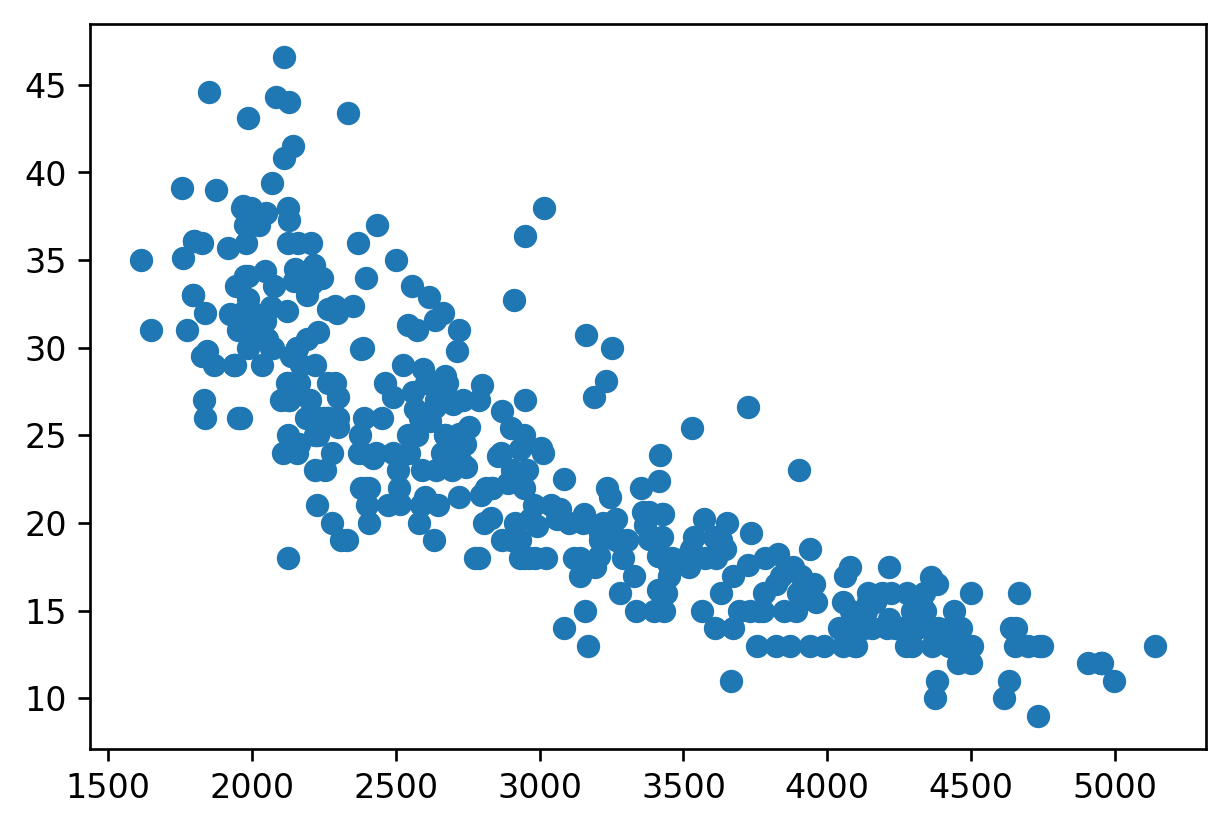

In [ ]:
plt.scatter(data['WGT'],data['MPG'])

In [ ]:
data.sort_values(by='WGT')

,MPG,CYL,ENG,WGT
53,35.000000,4,72.0,1613
142,31.000000,4,76.0,1649
339,39.099998,4,79.0,1755
341,35.099998,4,81.0,1760
52,31.000000,4,71.0,1773
...,...,...,...,...
94,12.000000,8,455.0,4951
89,12.000000,8,429.0,4952
41,12.000000,8,383.0,4955
102,11.000000,8,400.0,4997


In [ ]:
x = data['WGT'].values
y = data['MPG'].values

In [ ]:
lowess_reg(x,y,2100,tricubic,0.01)

array(27.)

In [ ]:
xnew = np.arange(1500,5500,10)

In [ ]:
yhat = lowess_reg(x,y,xnew,tricubic,150)

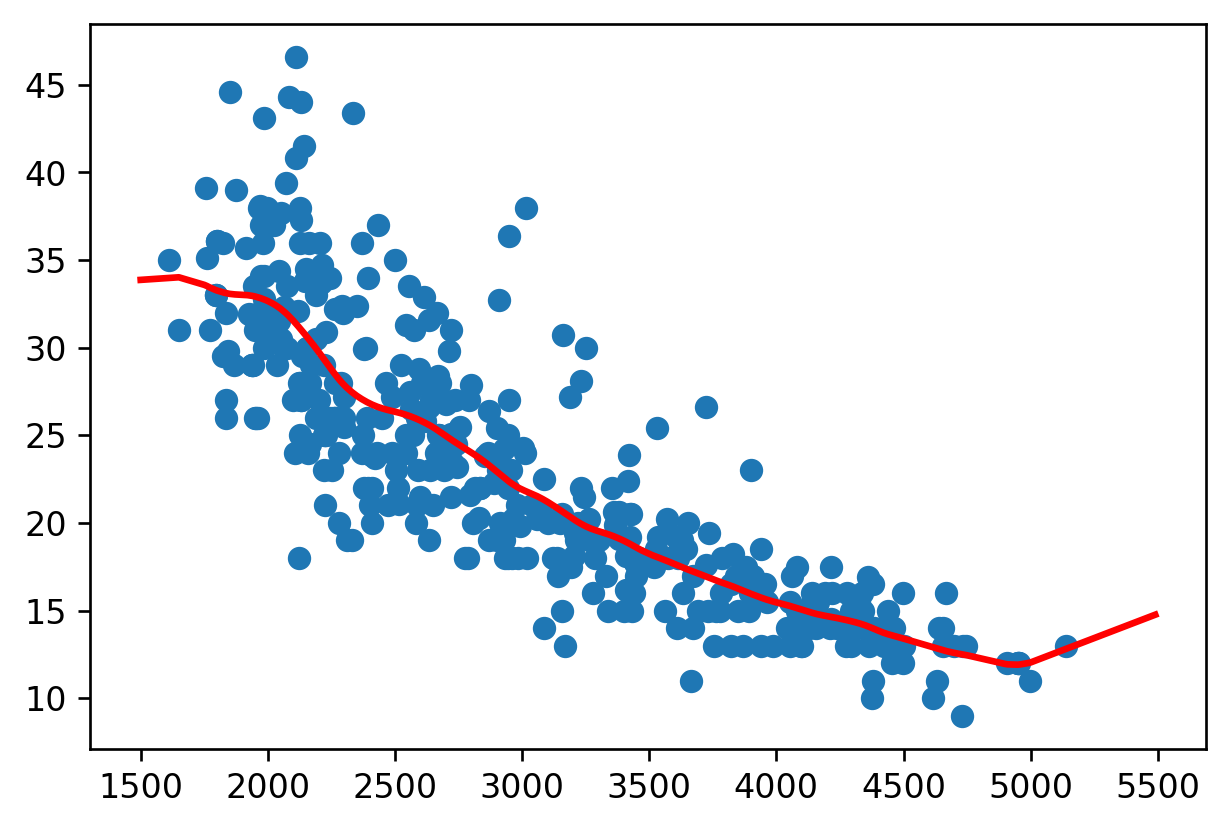

In [ ]:
plt.scatter(data['WGT'],data['MPG'])
plt.plot(xnew,yhat,color='red',lw=2)